In [35]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string as s
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_curve, auc

from sklearn.metrics  import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

from sentence_transformers import SentenceTransformer


In [36]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [37]:

train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0,names=['ID','Title','Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0,names=['ID','Title','Desc'])
#df = pd.concat([train_data,test_data])

train_data['text'] = train_data['Title'] + ' ' + train_data['Desc']
test_data['text'] = test_data['Title'] + ' ' + test_data['Desc']


In [38]:
train_data.head()

,ID,Title,Desc,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [39]:

test_data.head()

print(train_data.shape)
print(test_data.shape)

(120000, 4)
(7600, 4)


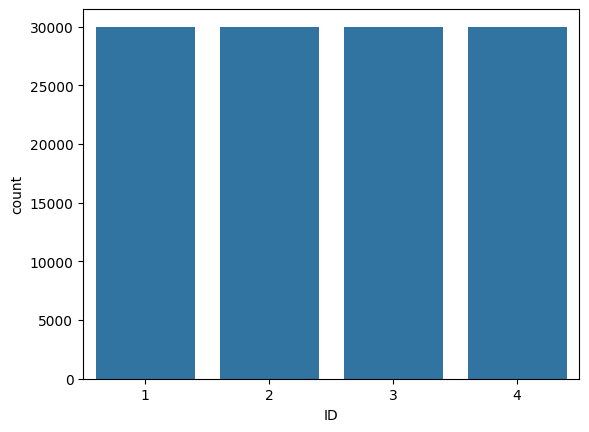

In [40]:

sns.countplot(x = 'ID', data = train_data)
plt.show()


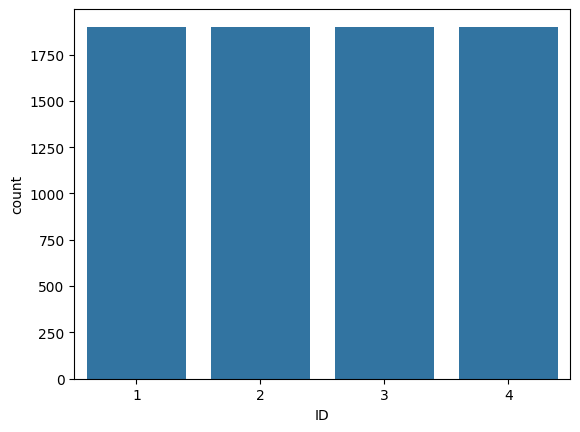

In [41]:
sns.countplot(x = 'ID', data = test_data)
plt.show()


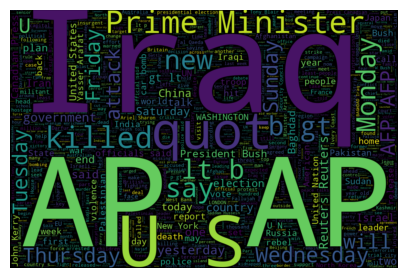

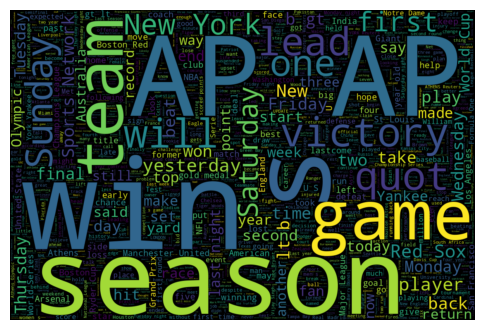

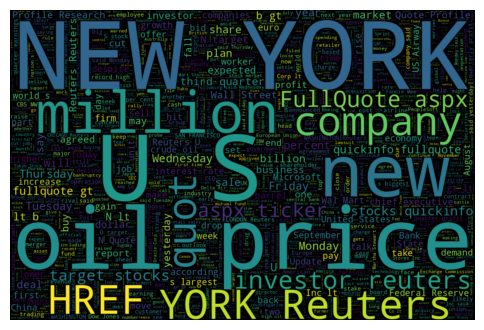

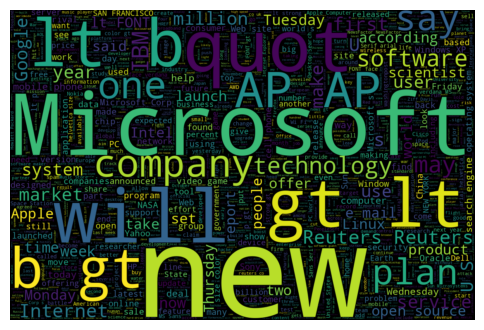

In [42]:


train_x = train_data.text[:60000]
test_x = test_data.text
train_y = train_data.ID[:60000]
test_y = test_data.ID

world = train_data[train_data['ID'] == 1]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sports_desc = train_data.loc[train_data['ID'] == 2, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

biz_desc = train_data.loc[train_data['ID'] == 3, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sci_desc = train_data.loc[train_data['ID'] == 4, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [43]:
import html
import re

def clean_html_noise(text: str) -> str:
   
    text = html.unescape(text)
    
   
    text = re.sub(r"<.*?>", "", text)
    
  
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

train_x = train_x.apply(clean_html_noise)
test_x = test_x.apply(clean_html_noise)

In [44]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)


In [45]:

def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])



<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_55/2033137638.py:2: SyntaxWarning: invalid escape sequence '\w'
  token = re.findall("[\w']+", text)


In [46]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)


In [47]:
import string
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)



In [48]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

In [49]:

from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)


In [50]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)


In [51]:

def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)


In [52]:
# X_train, X_val, y_train, y_val = train_test_split(
#     train_x,
#     train_y,
#     test_size=0.2,
#     stratify=train_y,
#     random_state=42
# )

In [53]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2') 
train_texts = train_x.tolist()
test_texts = test_x.tolist()
X_train_bert = bert_model.encode(train_texts, batch_size=64, show_progress_bar=True)
X_test_bert  = bert_model.encode(test_texts, batch_size=64, show_progress_bar=True)

print("Train embeddings shape:", X_train_bert.shape)
print("Test embeddings shape:", X_test_bert.shape)

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Train embeddings shape: (60000, 384)
Test embeddings shape: (7600, 384)


In [54]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_bert)
X_test_scaled  = scaler.transform(X_test_bert)

k = 300  
selector_bert = SelectKBest(score_func=chi2, k=k)
X_train_sel = selector_bert.fit_transform(X_train_scaled, train_y)
X_test_sel  = selector_bert.transform(X_test_scaled)

selected_features = X_train_sel.shape[1]
feature_ratio = selected_features / X_train_bert.shape[1]

selected_feature_indices = np.where(selector_bert.get_support())[0]

print(f"Total features (before selection): {X_train_bert.shape[1]}")
print(f"Selected features (after χ²): {selected_features}")
print(f"Feature selection ratio: {feature_ratio:.4f}")
print("First 20 selected feature indices:", selected_feature_indices[:20])


Total features (before selection): 384
Selected features (after χ²): 300
Feature selection ratio: 0.7812
First 20 selected feature indices: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 16 17 18 21 22 24 28]


In [55]:
# Lấy điểm chi-square của tất cả các feature
chi2_scores = selector_bert.scores_

# In ra 10 điểm đầu tiên làm ví dụ
print("Chi-square scores of first 10 features:")
print(chi2_scores[:10])

# In ra score của các feature được chọn (k=300)
selected_chi2_scores = chi2_scores[selected_feature_indices]
print("\nChi-square scores of first 20 selected features:")
print(selected_chi2_scores[:20])


Chi-square scores of first 10 features:
[ 89.31839615 207.98996313  32.3818034  150.23347887  33.28534765
 184.36382534  17.99898836 171.40607749 138.61152445 105.89908755]

Chi-square scores of first 20 selected features:
[ 89.31839615 207.98996313  32.3818034  150.23347887  33.28534765
 184.36382534 171.40607749 138.61152445 105.89908755 461.89834794
 175.49221997 186.80026683 164.5205931   43.4699881  161.5474002
  73.13524799 151.25208071 325.39182629  62.89492073 156.07360998]


In [56]:
# --- In bảng 20 feature đầu được chọn kèm chi2 score ---
import pandas as pd

# Lấy score chi2 của các feature được chọn
selected_chi2_scores = chi2_scores[selected_feature_indices]

# Tạo DataFrame để hiển thị trực quan
df_selected_features = pd.DataFrame({
    "Feature Index": selected_feature_indices,
    "Chi2 Score": selected_chi2_scores
})

# In 20 feature đầu tiên
print("Top 20 selected features with their chi-square scores:")
display(df_selected_features.head(20))


Top 20 selected features with their chi-square scores:


,Feature Index,Chi2 Score
0,0,89.318396
1,1,207.989963
2,2,32.381803
3,3,150.233479
4,4,33.285348
5,5,184.363825
6,7,171.406077
7,8,138.611524
8,9,105.899088
9,10,461.898348


In [57]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_sel,
    train_y,
    test_size=0.15,
    stratify=train_y,
    random_state=42
)

print(f"\nFinal training set size: {X_train_final.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_sel.shape[0]}")



Final training set size: 51000
Validation set size: 9000
Test set size: 7600


In [58]:
def eval_model(y_true, y_pred, dataset_name="Test"):
    """Evaluate model performance"""
    results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1": f1_score(y_true, y_pred, average='macro')
    }
    
    print(f"\n{dataset_name} set results:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1 Score:  {results['f1']:.4f}")
    print(f"  F1 per class: {f1_score(y_true, y_pred, average=None)}")
    
    return results


In [59]:
# Define hyperparameter grid
n_neighbors_list = [3, 5, 7, 9, 11, 13, 15]
weights_list = ['uniform', 'distance']
metric_list = ['cosine', 'euclidean', 'manhattan']

print("\nHyperparameters to test:")
print(f"  n_neighbors: {n_neighbors_list}")
print(f"  weights: {weights_list}")
print(f"  metric: {metric_list}")
print(f"\nTotal combinations: {len(n_neighbors_list) * len(weights_list) * len(metric_list)}")



Hyperparameters to test:
  n_neighbors: [3, 5, 7, 9, 11, 13, 15]
  weights: ['uniform', 'distance']
  metric: ['cosine', 'euclidean', 'manhattan']

Total combinations: 42


In [60]:

results_list = []
experiment_count = 0

print("\n" + "-"*60)
print("Starting hyperparameter tuning on validation set...")
print("-"*60)

for n_neighbors in n_neighbors_list:
    for weights in weights_list:
        for metric in metric_list:
            experiment_count += 1
            
            print(f"\nExperiment {experiment_count}:")
            print(f"  n_neighbors={n_neighbors}, weights='{weights}', metric='{metric}'")
            
            # Train model
            knn = KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights=weights,
                metric=metric
            )
            
            knn.fit(X_train_final, y_train_final)
            
            # Predict on validation set
            val_pred = knn.predict(X_val)
            
            # Evaluate
            val_results = eval_model(y_val, val_pred, dataset_name="Validation")
            
            # Store results
            results_list.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy': val_results['accuracy'],
                'precision': val_results['precision'],
                'recall': val_results['recall'],
                'f1': val_results['f1']
            })



------------------------------------------------------------
Starting hyperparameter tuning on validation set...
------------------------------------------------------------

Experiment 1:
  n_neighbors=3, weights='uniform', metric='cosine'

Validation set results:
  Accuracy:  0.8916
  Precision: 0.8914
  Recall:    0.8917
  F1 Score:  0.8916
  F1 per class: [0.88127559 0.95364536 0.85608343 0.87521739]

Experiment 2:
  n_neighbors=3, weights='uniform', metric='euclidean'

Validation set results:
  Accuracy:  0.8913
  Precision: 0.8912
  Recall:    0.8915
  F1 Score:  0.8913
  F1 per class: [0.8820358  0.95480099 0.85522042 0.87320886]

Experiment 3:
  n_neighbors=3, weights='uniform', metric='manhattan'

Validation set results:
  Accuracy:  0.8906
  Precision: 0.8905
  Recall:    0.8908
  F1 Score:  0.8906
  F1 per class: [0.88044886 0.95510941 0.85549133 0.87152778]

Experiment 4:
  n_neighbors=3, weights='distance', metric='cosine'

Validation set results:
  Accuracy:  0.8923
  Pr

In [61]:

# Create DataFrame of results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('f1', ascending=False)

print("\nTop 10 configurations by F1 score:")
print(results_df.head(10).to_string(index=False))

# Best configuration
best_config = results_df.iloc[0]
print("\n" + "="*60)
print("BEST CONFIGURATION")
print("="*60)
print(f"n_neighbors: {int(best_config['n_neighbors'])}")
print(f"weights: {best_config['weights']}")
print(f"metric: {best_config['metric']}")
print(f"\nValidation Performance:")
print(f"  Accuracy:  {best_config['accuracy']:.4f}")
print(f"  Precision: {best_config['precision']:.4f}")
print(f"  Recall:    {best_config['recall']:.4f}")
print(f"  F1 Score:  {best_config['f1']:.4f}")


Top 10 configurations by F1 score:
 n_neighbors  weights    metric  accuracy  precision   recall       f1
          15 distance    cosine  0.899111   0.899115 0.899574 0.899098
          13 distance    cosine  0.899000   0.899069 0.899505 0.899014
           9 distance euclidean  0.899000   0.899105 0.899428 0.899012
          11 distance euclidean  0.899000   0.899030 0.899468 0.898985
          11 distance    cosine  0.898889   0.898896 0.899330 0.898878
           9 distance    cosine  0.898444   0.898496 0.898842 0.898470
           7 distance euclidean  0.898333   0.898382 0.898693 0.898329
           7 distance    cosine  0.898000   0.897999 0.898361 0.898056
           7 distance manhattan  0.897778   0.897836 0.898147 0.897751
          13 distance euclidean  0.897444   0.897533 0.897979 0.897462

BEST CONFIGURATION
n_neighbors: 15
weights: distance
metric: cosine

Validation Performance:
  Accuracy:  0.8991
  Precision: 0.8991
  Recall:    0.8996
  F1 Score:  0.8991


In [62]:

print("\n" + "="*60)
print("9. TRAINING FINAL MODEL ON FULL TRAINING DATA")
print("="*60)

best_knn = KNeighborsClassifier(
    n_neighbors=int(best_config['n_neighbors']),
    weights=best_config['weights'],
    metric=best_config['metric']
)

print(f"\nTraining final model with best hyperparameters on {X_train_sel.shape[0]} samples...")
best_knn.fit(X_train_sel, train_y)




9. TRAINING FINAL MODEL ON FULL TRAINING DATA

Training final model with best hyperparameters on 60000 samples...


KNeighborsClassifier(metric='cosine', n_neighbors=15, weights='distance')

In [63]:
print("\n" + "="*60)
print("10. FINAL EVALUATION ON TEST SET")
print("="*60)

print("\nMaking predictions on test set...")
test_pred = best_knn.predict(X_test_sel)

print("\nFirst 20 actual labels:")
print(test_y.tolist()[:20])
print("\nFirst 20 predicted labels:")
print(test_pred.tolist()[:20])


10. FINAL EVALUATION ON TEST SET

Making predictions on test set...

First 20 actual labels:
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

First 20 predicted labels:
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4]



Test set results:
  Accuracy:  0.8901
  Precision: 0.8904
  Recall:    0.8901
  F1 Score:  0.8900
  F1 per class: [0.89634801 0.95511482 0.84375832 0.8649344 ]


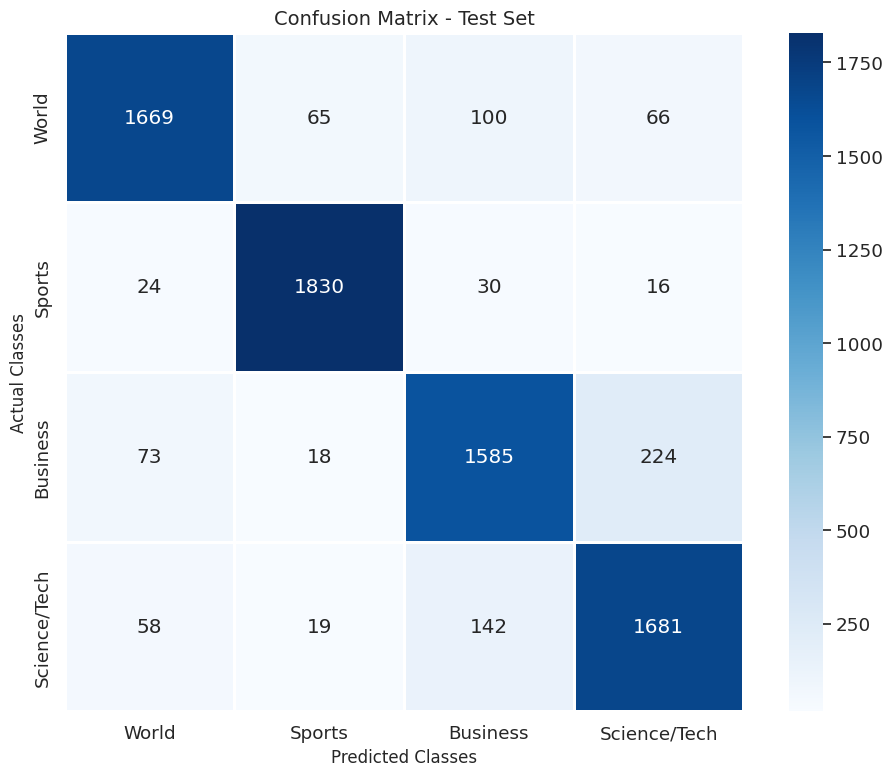

In [64]:
final_results = eval_model(test_y, test_pred, dataset_name="Test")
def plot_confusion_matrix(y_true, y_pred, color='Blues'):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['World', 'Sports', 'Business', 'Science/Tech'], 
                         columns=['World', 'Sports', 'Business', 'Science/Tech'])
    
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_df, cmap=color, linewidths=1, annot=True, 
                square=True, fmt='d', cbar=True)
    plt.xlabel("Predicted Classes", fontsize=12)
    plt.ylabel("Actual Classes", fontsize=12)
    plt.title("Confusion Matrix - Test Set", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_y, test_pred, color='Blues')

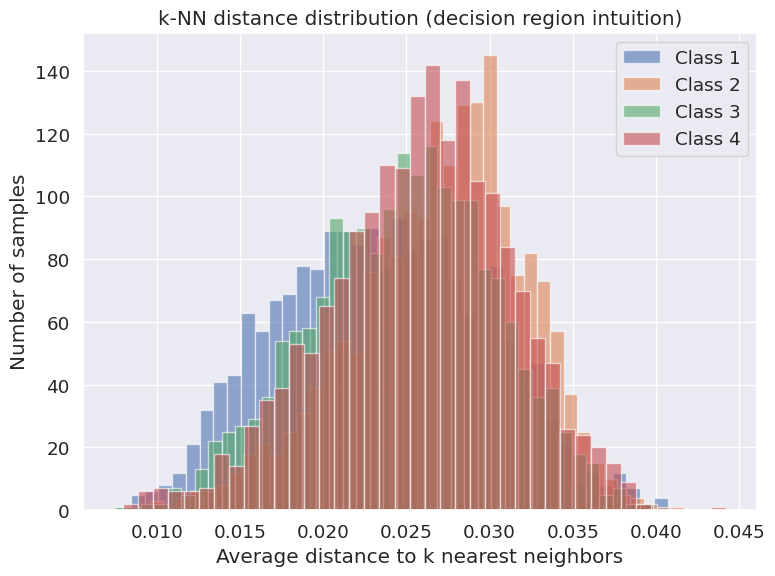

In [65]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

nn = NearestNeighbors(
    n_neighbors=int(best_config['n_neighbors']),
    metric=best_config['metric']
)

nn.fit(X_train_sel)

distances, neighbors = nn.kneighbors(X_test_sel)

mean_distances = distances.mean(axis=1)

plt.figure(figsize=(8, 6))

for label in np.unique(test_y):
    class_dist = mean_distances[test_y == label]
    plt.hist(
        class_dist,
        bins=40,
        alpha=0.6,
        label=f"Class {label}"
    )

plt.xlabel("Average distance to k nearest neighbors")
plt.ylabel("Number of samples")
plt.title("k-NN distance distribution (decision region intuition)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
print("\n" + "="*60)
print("FINAL SUMMARY REPORT")
print("="*60)

print("\n1. MÔ HÌNH:")
print("   - Thuật toán: K-Nearest Neighbors (k-NN)")
print("   - Phương pháp biểu diễn: BERT embeddings (all-MiniLM-L6-v2)")

print("   - Phương pháp chọn đặc trưng: Chi-square test")

print("\n2. HUẤN LUYỆN:")
print(f"   - Số mẫu huấn luyện: {len(train_y)}")
print(f"   - Số mẫu kiểm tra: {len(test_y)}")
print("   - Tiền xử lý: HTML cleaning, URL removal, tokenization,")
print("     lowercase, stopword removal, punctuation removal,")
print("     number removal, stemming")

print("\n3. ĐIỀU CHỈNH THAM SỐ:")
print(f"   - Số lần thử nghiệm: {experiment_count}")
print("   - Tham số được thử nghiệm:")
print(f"     + n_neighbors: {n_neighbors_list}")
print(f"     + weights: {weights_list}")
print(f"     + metric: {metric_list}")
print("   - Phương pháp: Grid Search với validation set (15% của train)")

print("\n4. THAM SỐ TỐI ÂU:")
print(f"   - n_neighbors: {int(best_config['n_neighbors'])}")
print(f"   - weights: {best_config['weights']}")
print(f"   - metric: {best_config['metric']}")

print("\n5. HIỆU QUẢ MÔ HÌNH:")
print("   Validation Set:")
print(f"     - Accuracy:  {best_config['accuracy']:.4f} ({best_config['accuracy']*100:.2f}%)")
print(f"     - Precision: {best_config['precision']:.4f}")
print(f"     - Recall:    {best_config['recall']:.4f}")
print(f"     - F1 Score:  {best_config['f1']:.4f}")

print("\n   Test Set:")
print(f"     - Accuracy:  {final_results['accuracy']:.4f} ({final_results['accuracy']*100:.2f}%)")
print(f"     - Precision: {final_results['precision']:.4f}")
print(f"     - Recall:    {final_results['recall']:.4f}")
print(f"     - F1 Score:  {final_results['f1']:.4f}")

print("\n" + "="*60)
print("HOÀN THÀNH!")
print("="*60)


FINAL SUMMARY REPORT

1. MÔ HÌNH:
   - Thuật toán: K-Nearest Neighbors (k-NN)
   - Phương pháp biểu diễn: BERT embeddings (all-MiniLM-L6-v2)
   - Phương pháp chọn đặc trưng: Chi-square test

2. HUẤN LUYỆN:
   - Số mẫu huấn luyện: 60000
   - Số mẫu kiểm tra: 7600
   - Tiền xử lý: HTML cleaning, URL removal, tokenization,
     lowercase, stopword removal, punctuation removal,
     number removal, stemming

3. ĐIỀU CHỈNH THAM SỐ:
   - Số lần thử nghiệm: 42
   - Tham số được thử nghiệm:
     + n_neighbors: [3, 5, 7, 9, 11, 13, 15]
     + weights: ['uniform', 'distance']
     + metric: ['cosine', 'euclidean', 'manhattan']
   - Phương pháp: Grid Search với validation set (15% của train)

4. THAM SỐ TỐI ÂU:
   - n_neighbors: 15
   - weights: distance
   - metric: cosine

5. HIỆU QUẢ MÔ HÌNH:
   Validation Set:
     - Accuracy:  0.8991 (89.91%)
     - Precision: 0.8991
     - Recall:    0.8996
     - F1 Score:  0.8991

   Test Set:
     - Accuracy:  0.8901 (89.01%)
     - Precision: 0.8904
  

In [67]:
print("\n" + "="*60)
print("13. SAVING MODEL AND COMPONENTS")
print("="*60)

import pickle
import joblib
import os

save_dir = './saved_model'
os.makedirs(save_dir, exist_ok=True)

print(". Saving k-NN model...")
joblib.dump(best_knn, f'{save_dir}/knn_model.pkl')
print(f"   ✓ Saved to: {save_dir}/knn_model.pkl")


print("\n2. Saving MinMaxScaler...")
joblib.dump(scaler, f'{save_dir}/scaler.pkl')
print(f"   ✓ Saved to: {save_dir}/scaler.pkl")

print("\n3. Saving SelectKBest selector...")
joblib.dump(selector_bert, f'{save_dir}/selector.pkl')
print(f"  Saved to: {save_dir}/selector.pkl")

print("\n4. Saving configuration...")
config = {
    'bert_model_name': 'all-MiniLM-L6-v2',
    'k_features': k,
    'best_params': {
        'n_neighbors': int(best_config['n_neighbors']),
        'weights': best_config['weights'],
        'metric': best_config['metric']
    }
}
with open(f'{save_dir}/config.pkl', 'wb') as f:
    pickle.dump(config, f)
print(f"   ✓ Saved to: {save_dir}/config.pkl")

print("\n" + "="*60)
print("ALL COMPONENTS SAVED SUCCESSFULLY!")
print("="*60)
print(f"\nSaved files in '{save_dir}/':")
print("  - knn_model.pkl  : Trained k-NN model")
print("  - scaler.pkl     : MinMaxScaler")
print("  - selector.pkl   : SelectKBest feature selector")
print("  - config.pkl     : Model configuration")


13. SAVING MODEL AND COMPONENTS
. Saving k-NN model...
   ✓ Saved to: ./saved_model/knn_model.pkl

2. Saving MinMaxScaler...
   ✓ Saved to: ./saved_model/scaler.pkl

3. Saving SelectKBest selector...
  Saved to: ./saved_model/selector.pkl

4. Saving configuration...
   ✓ Saved to: ./saved_model/config.pkl

ALL COMPONENTS SAVED SUCCESSFULLY!

Saved files in './saved_model/':
  - knn_model.pkl  : Trained k-NN model
  - scaler.pkl     : MinMaxScaler
  - selector.pkl   : SelectKBest feature selector
  - config.pkl     : Model configuration
